In [1]:
from scipy.ndimage import affine_transform
import tifffile as tiff
import os
import numpy as np
import copy
from pathlib import Path
import sys
import matplotlib.pyplot as plt

PIPELINE_ROOT =  Path().resolve().parent
sys.path.append(PIPELINE_ROOT.as_posix())

In [2]:
from image_manipulation.pipeline_process import Pipeline
from image_manipulation.elastix_manager import create_downsampled_transforms
from utilities.utilities_registration import (
    parameters_to_rigid_transform,
    rigid_transform_to_parmeters,
)
from settings import data_path, host, password, user, schema
channel = 1
downsample = True
tg = False
debug = False
rescan_number = 0

In [3]:
class ManualAligner(Pipeline):    
    
    def __init__(self, animal, moving_index):
        # pipeline = Pipeline(animal, rescan_number, channel, downsample, data_path, tg, debug)

        super().__init__(animal, rescan_number, channel, downsample, data_path, tg, debug)
        sectioni = moving_index
        self.moving_index = moving_index
        MOVING_DIR = os.path.join(self.fileLocationManager.prep, 'CH3', 'thumbnail_aligned_iteration_1')
        FIXED_DIR = self.fileLocationManager.get_thumbnail_aligned(channel=1)
        self.fixed_file = os.path.join(FIXED_DIR, f'{str(moving_index).zfill(3)}.tif')
        self.moving_file = os.path.join(MOVING_DIR, f'{str(moving_index).zfill(3)}.tif')
        self.moving = tiff.imread(self.moving_file)
        self.fixed = tiff.imread(self.fixed_file)
        self.center = self.get_rotation_center()
        
    def transform_image(self,img,T):
        matrix = T[:2,:2]
        offset = T[:2,2]
        offset = np.flip(offset)
        img = affine_transform(img,matrix.T,offset)
        return img
    
    def evaluate_transformation(self):
        # img1 is moving
        
        rotation, xshift, yshift = self.load_elastix_transformation(self.animal, self.moving_index, 2)
        T = self.parameters_to_rigid_transform(rotation, xshift, yshift, self.center)
        img1 = self.transform_image(self.moving, T)
        self.compare_two_image(img1,self.fixed)        
        
    def compare_two_imageXXX(self,img1,img2):
        img1,img2 = img1.astype(float),img2.astype(float)
        vmin_max1 = img1[img1!=0].min(),img1[img1!=0].max()
        vmin_max2 = img2[img2!=0].min(),img2[img2!=0].max()
        img1[img1<2000]=np.nan
        img2[img2<2000]=np.nan
        plt.figure(figsize=[20,20])
        plt.imshow(img1,cmap='Reds',vmin=vmin_max1[0], vmax=vmin_max1[1]*0.8)
        plt.imshow(img2,alpha=0.5,cmap='Blues',vmin=vmin_max2[0], vmax=vmin_max2[1]*0.8)
        
    def compare_two_image(self,img1,img2):
        plt.figure(figsize=[20,20])
        plt.imshow(img1, cmap='Reds')
        plt.imshow(img2, alpha=0.5)        
    
    
    def compare_untransformed(self):
        self.compare_two_image(self.moving,self.fixed)
        
    
    def evaluate_current_transformation(self):
        T1 = self.get_transformation_of_sectioni(self.moving_index)
        T2 = self.get_transformation_of_sectioni(self.fixed_index)
        self.evalulate_transformation(self.moving, self.fixed, T1, T2)
        plt.title(self.moving_index);

In [4]:
prep_id = 'DK97'
section = 46
aligner = ManualAligner(prep_id, section)

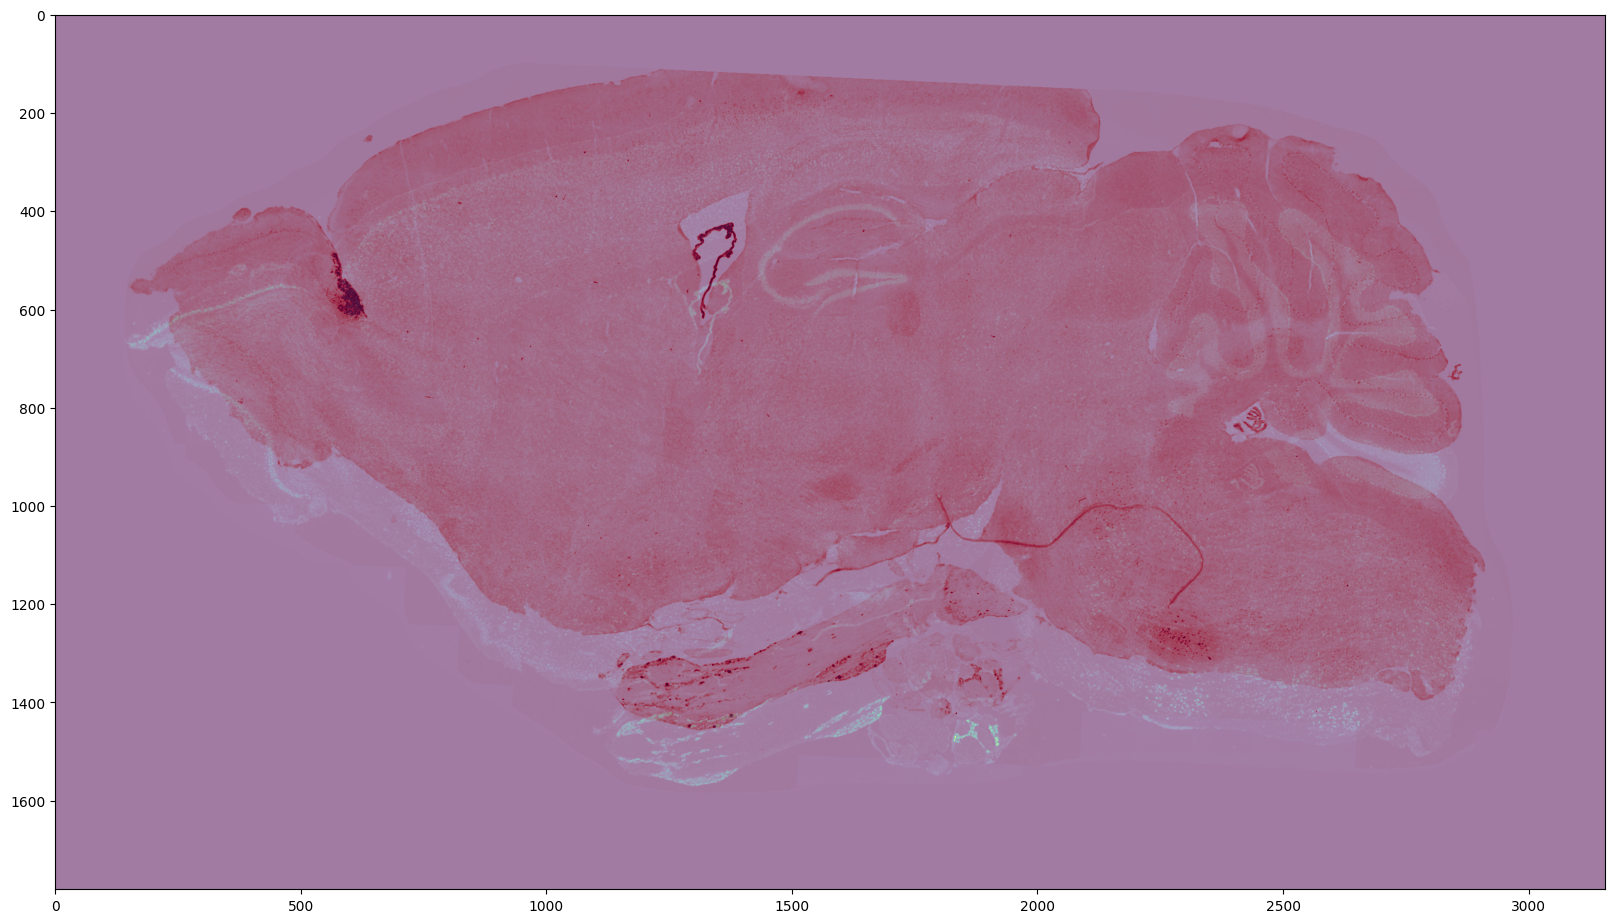

In [5]:
aligner.compare_untransformed()

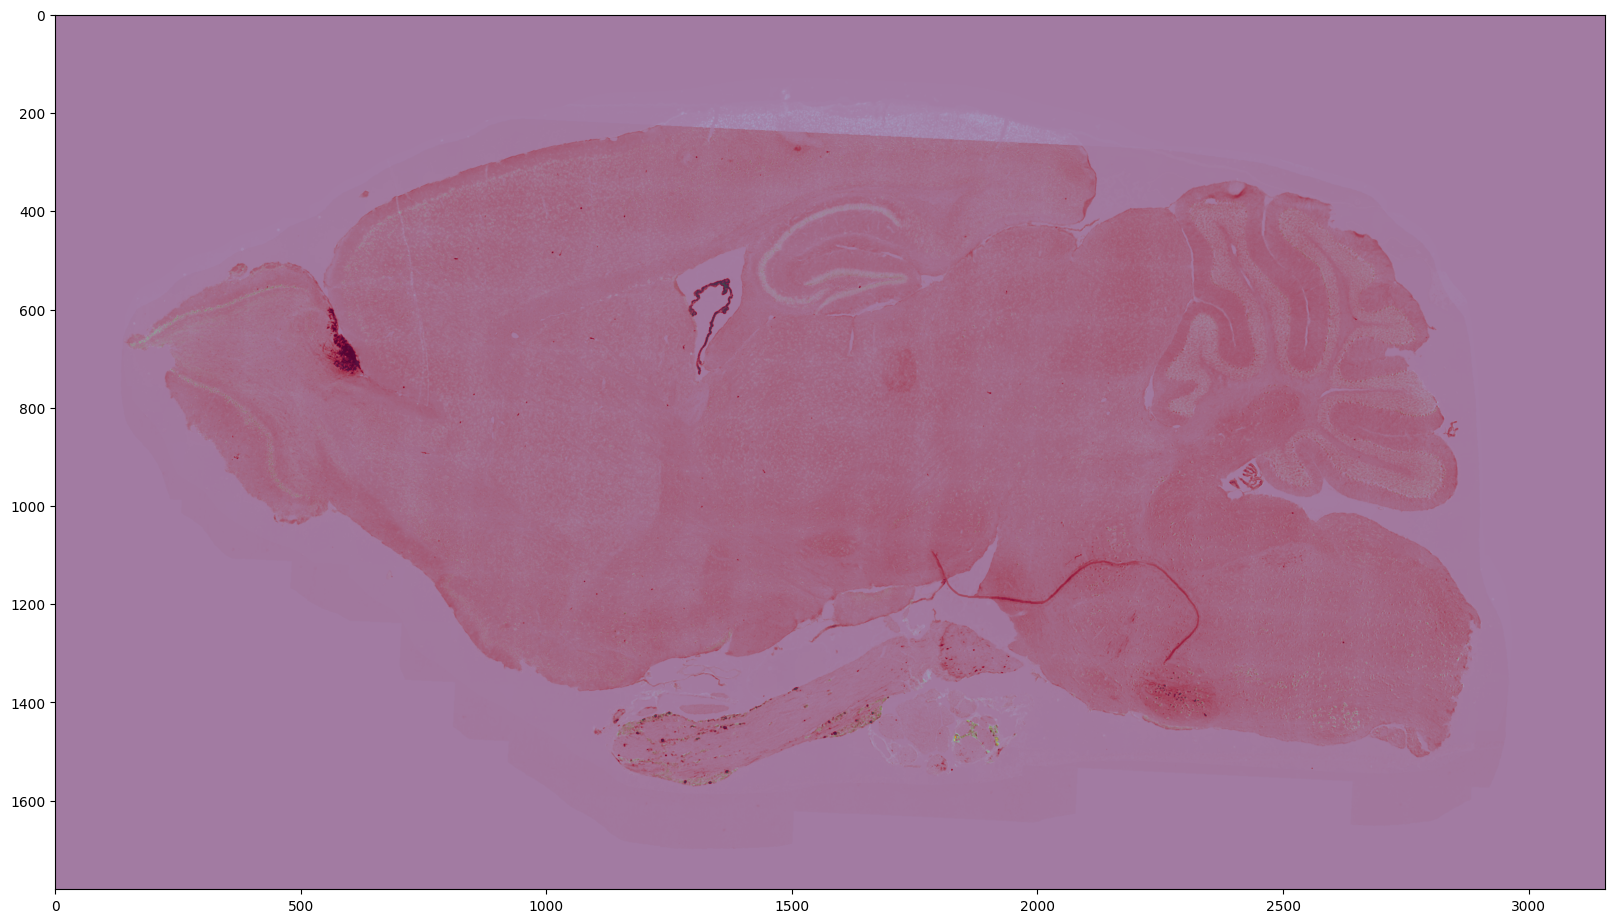

In [6]:
aligner.evaluate_transformation()

In [8]:
rotation, xshift, yshift = aligner.load_elastix_transformation(aligner.animal, aligner.moving_index, iteration=2)
section = str(aligner.moving_index).zfill(3)
print(f'moving index/section = {aligner.moving_index}')
print(f'rotation = {rotation}')
print(f'xshift = {xshift}')
print(f'yshift = {yshift}')

moving index/section = 46
rotation = -0.00116355
xshift = 7.70487
yshift = -114.28
